In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp
sys.path.append('/home/chen/Testarea/prototype/Foreground')
sys.path.append('/home/chen/Testarea/A_NEW_WORK')

# from lensingb_mine import *
# from noise_making import *
from utils_mine import *
# from phi_noise_making import *
# from generate_map import *
# from lenspyx.utils import camb_clfile
# from lenspyx.utils_hp import synalm, almxfl, alm2cl
# from map_coadded import *

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

import pymaster as nm


loading modules...
loading modules...


# Set parameters

In [3]:
nside = 2048
lmax = 3*nside-1 
lmax_len = lmax # desired lmax of the lensed field.
dlmax = lmax    # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6  # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax
Tcmb = 2.7255e6
npix = hp.nside2npix(nside)



freqs = [27, 39, 93, 145, 225, 280]

theta_ac = [7.4, 5.1, 2.2, 1.4, 1.0, 0.9]

ac2rad = np.pi/10800.
theta_rad = np.array(theta_ac)*ac2rad

nlev =  [52, 27, 5.8, 6.3, 15, 37]

lcut = [3000, 4000, lmax, lmax, lmax, lmax]

In [4]:
freqs = [27, 39, 93, 145, 225, 280]
nlev = [52, 27, 5.8, 6.3, 15, 37]
theta_ac = [7.4, 5.1, 2.2, 1.4, 1.0, 0.9]

N_red_T_s = [100, 39, 230, 1500, 17000, 31000]
N_red_T = [value / (20000 * 3600) for value in N_red_T_s]
l_knee_T = [1000, 1000, 1000, 1000, 1000, 1000] 
alpha_knee_T = [-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, ]

N_red_P = nlev
l_knee_P = [700, 700, 700, 700, 700, 700, ] 
alpha_knee_P = [-1.4, -1.4, -1.4, -1.4, -1.4, -1.4, ]

ac2rad = np.pi/10800.
theta_rad = np.array(theta_ac)*ac2rad

ellmax = lmax
lcut = [ellmax, ellmax, ellmax, ellmax, ellmax, ellmax]

# Load masks

In [5]:
mask_ali = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_c/AliCPT_LAT_cross_PLANCK_2048_bi_C.fits')
mask_so = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_c/SO_LAT_cross_PLANCK_2048_bi_C.fits')

mask_ali[mask_ali<0.5] = 0
mask_ali[mask_ali>=0.5] = 1

mask_so[mask_so<0.5] = 0
mask_so[mask_so>=0.5] = 1


mask_comb_c = mask_ali + mask_so - mask_ali*mask_so
hp.write_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_c/ALI_LAT_add_SO_LAT_cross_PLANCK_2048_bi_C.fits', mask_comb_c, overwrite=True)

hp.write_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_c/AliCPT_LAT_cross_PLANCK_2048_bi_C.fits', mask_ali, overwrite=1)

hp.write_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_c/SO_LAT_cross_PLANCK_2048_bi_C.fits', mask_so, overwrite=1)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]


# Load simulations 

In [6]:
lensedcmb = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/lensedcmb_00000.fits', field=(0,))
ksz = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/ksz_00000.fits', field=(0,))
tsz_148 = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/tsz_148ghz_00000.fits', field=(0,))
rad_148 = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/rad_pts_148ghz_00000.fits', field=(0,))
cib_148 = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/ir_pts_148ghz_00000.fits', field=(0,))

mask_sz = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_sz_00000.fits')
mask_ps = hp.read_map('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask_ps_00000.fits')

# rad_148 = rad_148*mask_ps
# cib_148 = cib_148*mask_ps
# tsz_148 = tsz_148*mask_sz

In [7]:
def map_compression(nside,map=None,dat=None,savepath=None,flag='f2d'):
    """
    Given an patch sky map (.fits), we convert it to numpy array and save only non-zero pixels to a .dat file.
    OR
    Given a .dat file, we read it and convert it to a patch sky map (.fits).
    """
    def compress_array(arr):
        # Get the indices of non-zero elements
        non_zero_indices = np.nonzero(arr)
        # Get the values of the non-zero elements
        non_zero_values = arr[non_zero_indices]
        # Combine indices and values into a 2-row array
        compressed_array = np.vstack((non_zero_indices[0], non_zero_values))
        return compressed_array

    def decompress_array(compressed_array, original_shape):
        # Create an empty array of the original shape
        decompressed_array = np.zeros(original_shape)
        # Extract indices and values
        indices = compressed_array[0].astype(int)
        values = compressed_array[1]
        # Place the values back into the decompressed array
        decompressed_array[indices] = values
        return decompressed_array

    if flag == 'f2d':
        assert map is not None, "The map parameter cannot be None when flag is 'f2d'"
        map_array = []
        for i in np.arange(np.shape(map)[0]):
            map_array.append(compress_array(map[i]))
        if savepath is not None:
            np.save(savepath, map_array)
        else:
            return np.array(map_array)
        
    elif flag == 'd2f':
        assert dat is not None, "The dat parameter cannot be None when flag is 'd2f'"
        map_array = []
        for i in np.arange(np.shape(dat)[0]):
            map_array.append(decompress_array(dat[i],12*nside**2))
        if savepath is not None:
            hp.write_map(savepath, map_array)
        else:
            return np.array(map_array)

In [8]:
noise_hp = []
for i in range(6):

    noise_map_hp = map_compression(2048, dat=np.load(f'/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/TQU_N_0_{freqs[i]}.npy'),flag='d2f')[0]

    noise_hp.append(noise_map_hp)

In [9]:
def bl(fwhm, lmax=None, nside=None, pixwin=True):    #bl包括相当于beam window function 和 pixel window function,相当于e^-(l(l+1)* \sigma^2)(这是beam window function)
    """ Transfer function.

        * fwhm      : beam fwhm in arcmin
        * lmax      : lmax
        * pixwin    : whether include pixwin in beam transfer function
        * nside     : nside
    """
    assert lmax or nside
    lmax = min( 3 * nside - 1, lmax ) if nside and lmax else lmax if lmax else 3*nside - 1
    ret = hp.gauss_beam(fwhm * np.pi / 60. / 180., lmax=lmax)   #return: beam window function
    if pixwin:
        assert nside is not None
        ret *= hp.pixwin(nside, lmax=lmax)      #hp.pixwin: Return the pixel window function for the given nside
    return ret

def replace_fwhm_alm(alm,fwhm_old,fwhm_new,lmax):
    """
    replace old beam of alm with new beam in arcmin, notice the pixwin is included in the old beam by default.
    """
    bl_old = bl(fwhm_old, nside=nside, lmax=lmax, pixwin=False)    #Don't include pixwin in the old beam, otherwise it results in problem when partial sky.  
    bl_new = bl(fwhm_new, nside=nside, lmax=lmax, pixwin=False)    #hp.gauss_beam(fwhm_new,lmax=lmax,pol=True)
    alm_deconv = hp.almxfl(alm, 1/bl_old * bl_new)
    return alm_deconv

def replace_fwhm_map(nside,lmax,map,fwhm_old,fwhm_new):
    """
    replace old beam of map with new beam in arcmin, notice the pixwin is included in the old beam by default.
    """
    alm = hp.map2alm(map)
    alm_deconv = replace_fwhm_alm(alm, fwhm_old, fwhm_new, lmax)
    map_deconv = hp.alm2map(alm_deconv, nside)
    return map_deconv

def add_beam(fwhm_ac,nside,maps,lmax=None,pixwin=False):
    """
    Smooth the maps with beam fwhm_ac in arcmin and pixwin. 
    
    Better for full sky input CMB/FG maps (which will be convolved with beam and pixwin).
    """
    if lmax == None:
        lmax =3*nside-1
    transf = bl(fwhm_ac, nside=nside, lmax=lmax, pixwin=pixwin)
    alms = hp.map2alm(maps, lmax=lmax)
    alms_sm = []
    for i in range(3):
        alms_sm.append(hp.almxfl(alms[i], transf))
    maps_sm = hp.alm2map(alms_sm, nside, verbose=False)
    return maps_sm   

# Combine them to observation channels

In [10]:
from emission_freq_resp import *

obs_all = []
res_all = []
for i in range(6):
    gal_fg = hp.read_map(f'/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mmDL_2048/00000/fg_C/Ali_SO/fg_dsaf_{freqs[i]}GHz_2048_C.fits', field=(0,))

    exgal_fg = ksz + tSZ_interpolate(148, freqs[i], tsz_148) + radio_spectral_interpolate_poly(148, freqs[i], rad_148) + CIB_interpolate(148, freqs[i], cib_148)

    obs = lensedcmb + gal_fg + exgal_fg + replace_fwhm_map(nside, lcut[i], noise_hp[i], theta_ac[i], 0)

    obs_all.append(obs * mask_comb_c)

    res_all.append((obs-lensedcmb) * mask_comb_c)

tSZ scale factor = 2.004971582236876 (148GHz ->27GHz)
Radio scale factor = [68.95552559] (148GHz ->27GHz)
CIB scale factor = 0.05804629328959553 (148GHz ->27GHz)
tSZ scale factor = 1.9636517532000168 (148GHz ->39GHz)
Radio scale factor = [28.17073491] (148GHz ->39GHz)
CIB scale factor = 0.1025845283922728 (148GHz ->39GHz)
tSZ scale factor = 1.606007746937413 (148GHz ->93GHz)
Radio scale factor = [2.70597446] (148GHz ->93GHz)
CIB scale factor = 0.4144548149102405 (148GHz ->93GHz)
tSZ scale factor = 1.0381003145255459 (148GHz ->145GHz)
Radio scale factor = [1.0363513] (148GHz ->145GHz)
CIB scale factor = 0.9576507809889943 (148GHz ->145GHz)
tSZ scale factor = -0.11748452921944648 (148GHz ->225GHz)
Radio scale factor = [0.60339784] (148GHz ->225GHz)
CIB scale factor = 2.825920578927601 (148GHz ->225GHz)
tSZ scale factor = -1.0230040331257926 (148GHz ->280GHz)
Radio scale factor = [0.56862339] (148GHz ->280GHz)
CIB scale factor = 5.733958200050517 (148GHz ->280GHz)


# Here we go

In [11]:
from hilc import *

In [12]:
from spectral import *
comps = ['CMB', 'tSZ', 'kSZ', 'CIB', 'radio', 'noise'] #components in sky
gg_shot_noise = np.array([[8.7e-8, 6.22e-9, 0], [6.22e-9, 1.53e-7, 4.67e-8], [0, 4.67e-8, 2.88e-6]]) #index as gg_shot_noise[a][b] for blue, green, red
comps = ['CIB'] #'CMB', 'tSZ', 'kSZ', 'CIB', 'radio', 'noise'
CIB_model = 'mmDL_fit' # 'H13'，'P14'，'S10_basic', 'S10_high', 'S10_fit', 'mmDL_fit'
spectra1 = spectra(' ', 10000, freqs, comps, gg_shot_noise, CIB_model=CIB_model, noise=None) #use this line for SO and Planck noise levels

In [ ]:
alms_all = []
for i in range(6):
    alms_all.append(hp.map2alm(obs_all[i], lmax=3*nside-1))

In [16]:
# alms_res_all = []
# for i in range(6):
#     alms_res_all.append(hp.map2alm(res_all[i], lmax=3*nside-1))

In [17]:
def reproduce_ilc_map(alms, weights):
    res_alm = 0
    for i,freq in enumerate(freqs):
        res_alm += hp.almxfl(alms[i], weights[i])
    res_map = hp.alm2map(res_alm, nside)
    return res_map

In [18]:
DELTA_ELL = 120

In [19]:
ilc0 = standard_ILC(DELTA_ELL, spectra1, alms_all, lmax, freqs, np.mean(mask_comb_c))

alm_clean0, weight0 = ilc0.do_CILC()

map_clean0 = hp.alm2map(alm_clean0, nside, verbose=False)

constraint: 1.0000000000000004
None


/tmp/ipykernel_1692642/3396460479.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_clean0 = hp.alm2map(alm_clean0, nside, verbose=False)


In [20]:
ilc1 = ILC_deproj_tSZ(DELTA_ELL, spectra1, alms_all, lmax, freqs, np.mean(mask_comb_c))

alm_clean1, weight1 = ilc1.do_CILC()

map_clean1 = hp.alm2map(alm_clean1, nside, verbose=False)

constraint: 1.0000000000000266 7.460698725481052e-14
None


/tmp/ipykernel_1692642/2695938851.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_clean1 = hp.alm2map(alm_clean1, nside, verbose=False)


In [21]:
ilc2 = ILC_deproj_CIB(DELTA_ELL, spectra1, alms_all, lmax, freqs, np.mean(mask_comb_c))

alm_clean2, weight2 = ilc2.do_CILC()

map_clean2 = hp.alm2map(alm_clean2, nside, verbose=False)

constraint: 1.0000000000000016 0.0
None


/tmp/ipykernel_1692642/4002022538.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_clean2 = hp.alm2map(alm_clean2, nside, verbose=False)


In [22]:
ilc3 = ILC_deproj_tSZ_and_CIB(DELTA_ELL, spectra1, alms_all, lmax, freqs, np.mean(mask_comb_c))

alm_clean3, weight3 = ilc3.do_CILC()

map_clean3 = hp.alm2map(alm_clean3, nside, verbose=False)

constraint: 1.0000000000000426 4.973799150320701e-14 -1.0547118733938987e-15
None
(6, 6144)


/tmp/ipykernel_1692642/287003555.py:5: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_clean3 = hp.alm2map(alm_clean3, nside, verbose=False)


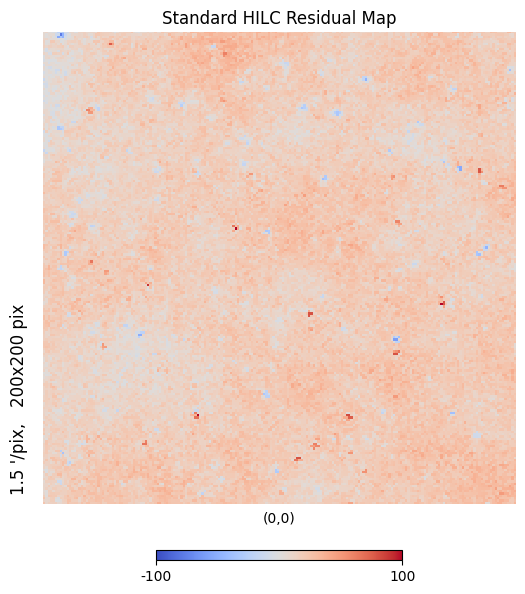

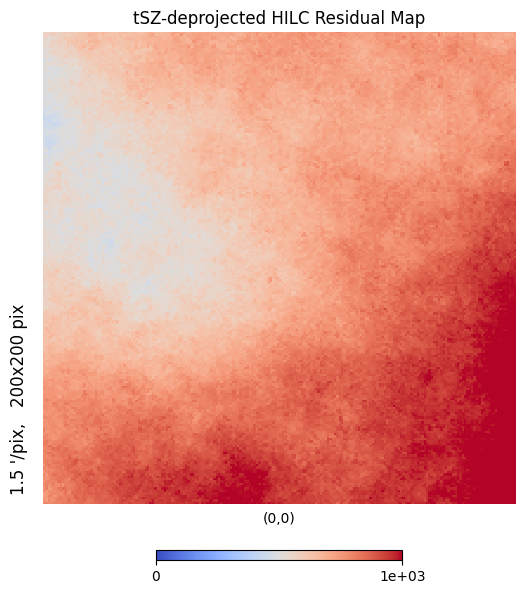

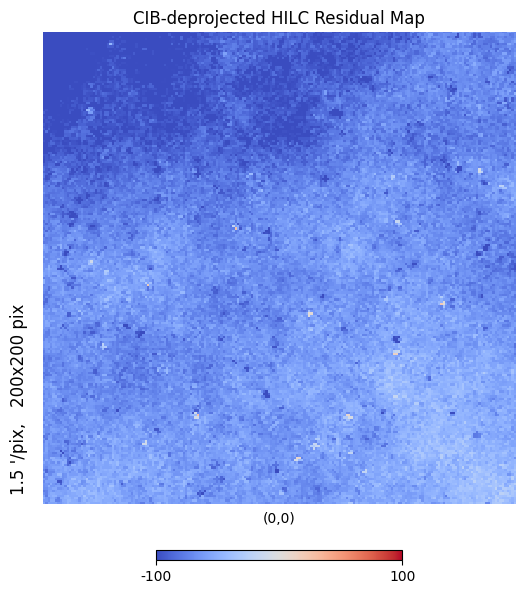

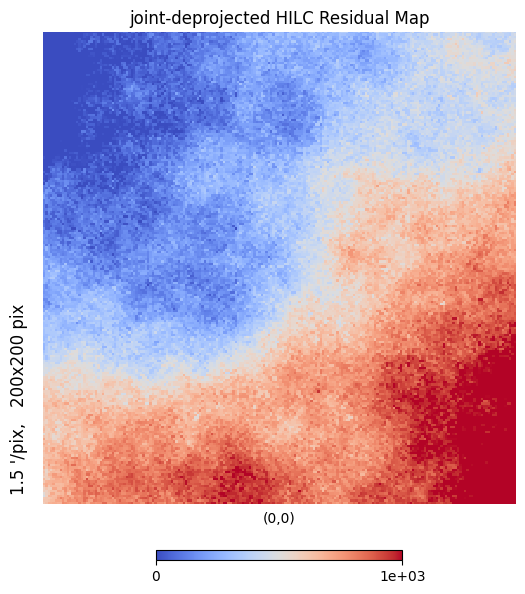

In [32]:
hp.gnomview((map_clean0-lensedcmb)*mask_comb_c, cmap='coolwarm', min=-100, max=100, title='Standard HILC Residual Map')
hp.gnomview((map_clean1-lensedcmb)*mask_comb_c, cmap='coolwarm', min=0, max=1000, title='tSZ-deprojected HILC Residual Map')
hp.gnomview((map_clean2-lensedcmb)*mask_comb_c, cmap='coolwarm', min=-100, max=100, title='CIB-deprojected HILC Residual Map')
hp.gnomview((map_clean3-lensedcmb)*mask_comb_c, cmap='coolwarm', min=0, max=1000, title='joint-deprojected HILC Residual Map')


In [21]:
def get_pseudo_cl(nside,mask_input,flag,bin,lmax=None,apo=False,f0=None,f2=None,is_Dell=True):
    """
        nside:
        mask_input:最好是1024的mask,否则apodization很慢;或者输入apodization后的mask
        flag: '00' '02' '22',依次为spin-0 x spin-0,spin-0 x spin-2,spin-2 x spin-2
        bin: 每个bin的多极项数目
        lmax: 用于计算pseudo-Cl的lmax,默认为-1,即使用3*nside-1
        apo: 是否输入了apodization后的mask
        f0: spin-0 field
        f2: spin-2 field
    """
        
    import numpy as np
    import healpy as hp
    import matplotlib.pyplot as plt

    # Import the NaMaster python wrapper
    import pymaster as nmt

    if lmax is None:
        lmax = 3*nside - 1
    if apo == True:
        mask = mask_input
    else:
        mask = nmt.mask_apodization(mask_input,  1., apotype="Smooth")           # apodization中的参数可以调整，这里为 1 degree
    #hp.orthview(mask, half_sky=True, rot=[180, 30, 0],cmap='YlGnBu_r',title='Apodized mask')
    print('mask apodization done')
    
    # Read healpix maps and initialize a spin-0 and spin-2 field
    
    # Initialize binning scheme with 'bin' ells per bandpower
    #b = nmt.NmtBin.from_nside_linear(nside, bin, is_Dell=is_Dell)
    b = nmt.NmtBin.from_lmax_linear(lmax, bin, is_Dell=is_Dell)
    ell_arr = b.get_effective_ells()
    if isinstance(f0, (list, tuple)):
        f0_1 = [f0[0]]
        f0_2 = [f0[1]]
    else:
        f0_1 = [f0]
        f0_2 = [f0]
    print(len(f0_1),len(f0_2))
    # Compute MASTER estimator
    # spin-0 x spin-0
    if flag == '00':
        f_01 = nmt.NmtField(mask, f0_1, lmax=lmax)  
        f_02 = nmt.NmtField(mask, f0_2, lmax=lmax)  

        print('pseudo cl calculating ')
        cl_00 = nmt.compute_full_master(f_01, f_02, b)    #TT为 cl_00[0]
        return ell_arr,cl_00

    # spin-0 x spin-2
    if flag == '02':
        f_0 = nmt.NmtField(mask, f0_1, lmax=lmax)  
        f_2 = nmt.NmtField(mask, f2, spin=2, purify_e=False, purify_b=False, n_iter_mask=3, lmax=lmax)  
        assert f_0 is not None
        assert f_2 is not None
        print('pseudo cl calculating ')
        cl_02 = nmt.compute_full_master(f_0, f_2, b)
        return ell_arr,cl_02
    
    # spin-2 x spin-2
    if flag == '22':
        f_2 = nmt.NmtField(mask, f2, spin=2, purify_e=False, purify_b=False, n_iter_mask=3, lmax=lmax)  
        assert f_2 is not None
        print('pseudo cl calculating ')
        cl_22 = nmt.compute_full_master(f_2, f_2, b)      #EE,BB 分别为 cl_22[0]，cl_22[3]
        return ell_arr,cl_22

# Calculate power spectra of ILC output and bias.

In [22]:
lbin, cl_cmb = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=lensedcmb*mask_comb_c, is_Dell=1)

mask apodization done
1 1
pseudo cl calculating 


In [23]:
lbin, cl_clean0 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=map_clean0*mask_comb_c, is_Dell=1)
lbin, cl_clean1 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=map_clean1*mask_comb_c, is_Dell=1)
lbin, cl_clean2 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=map_clean2*mask_comb_c, is_Dell=1)
lbin, cl_clean3 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=map_clean3*mask_comb_c, is_Dell=1)

mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1
pseudo cl calculating 


In [ ]:
lbin, cl_bias0 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=[(map_clean0-lensedcmb)*mask_comb_c,lensedcmb*mask_comb_c], is_Dell=1)
lbin, cl_bias1 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=[(map_clean1-lensedcmb)*mask_comb_c,lensedcmb*mask_comb_c], is_Dell=1)
lbin, cl_bias2 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=[(map_clean2-lensedcmb)*mask_comb_c,lensedcmb*mask_comb_c], is_Dell=1)
lbin, cl_bias3 = get_pseudo_cl(2048, mask_comb_c, '00', 40, lmax=6143, apo=True, f0=[(map_clean3-lensedcmb)*mask_comb_c,lensedcmb*mask_comb_c], is_Dell=1)

mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1
pseudo cl calculating 
mask apodization done
1 1


# standard ILC give the minimum residual, while keep much of the point-like residual from extragalactic foreground.

# Deprojecting a certain component mitigates the residual from it, while it may enhance other residual, and no longer the minimum-variance estimate.

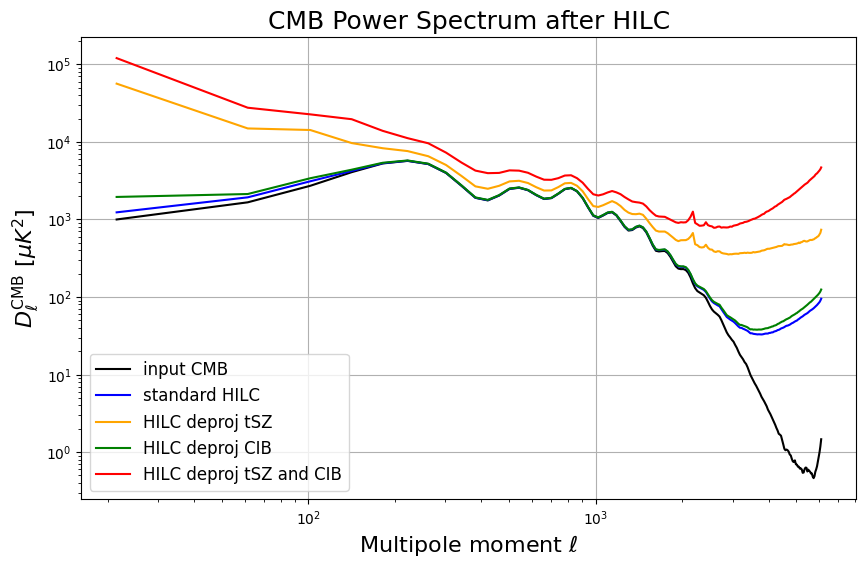

In [56]:
plt.figure(figsize=(10,6))

plt.loglog(lbin, cl_cmb[0], label='input CMB', color='black')
plt.loglog(lbin, cl_clean0[0], label='standard HILC', color='blue')
plt.loglog(lbin, cl_clean1[0], label='HILC deproj tSZ', color='orange')
plt.loglog(lbin, cl_clean2[0], label='HILC deproj CIB', color='green')
plt.loglog(lbin, cl_clean3[0], label='HILC deproj tSZ and CIB', color='red')
plt.xlabel(r'Multipole moment $\ell$', fontsize=16)
plt.ylabel(r'$D_\ell^{\mathrm{CMB}}$ [$\mu K^2$]', fontsize=16)
plt.title('CMB Power Spectrum after HILC', fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.show()

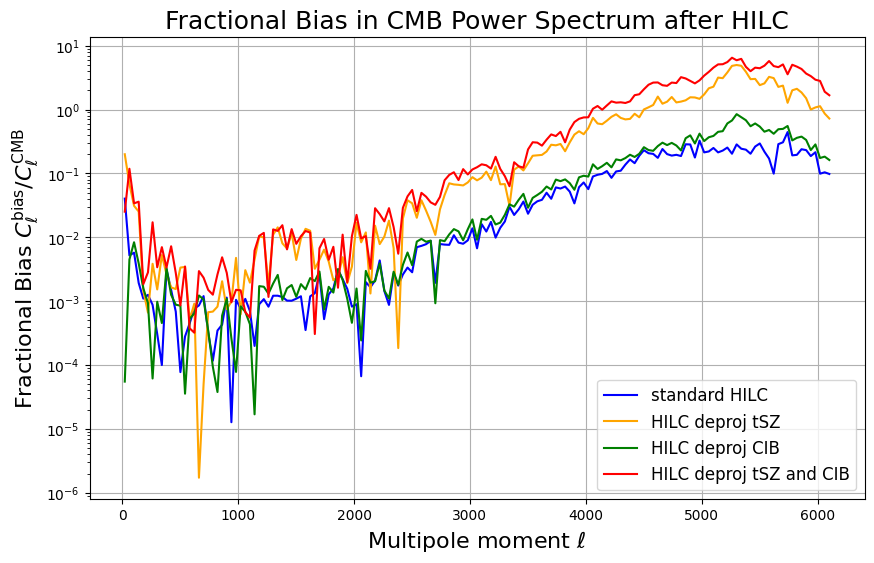

In [57]:
plt.figure(figsize=(10,6))

plt.semilogy(lbin, np.abs(cl_bias0[0])/cl_cmb[0], label='standard HILC', color='blue')
plt.semilogy(lbin, np.abs(cl_bias1[0])/cl_cmb[0], label='HILC deproj tSZ', color='orange')
plt.semilogy(lbin, np.abs(cl_bias2[0])/cl_cmb[0], label='HILC deproj CIB', color='green')
plt.semilogy(lbin, np.abs(cl_bias3[0])/cl_cmb[0], label='HILC deproj tSZ and CIB', color='red')
plt.xlabel(r'Multipole moment $\ell$', fontsize=16)
plt.ylabel(r'Fractional Bias $C_\ell^{\mathrm{bias}}/C_\ell^{\mathrm{CMB}}$', fontsize=16)
plt.title('Fractional Bias in CMB Power Spectrum after HILC', fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.show()